# Real Fake Job Prediction Project

## Libraries

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix,precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tabulate import tabulate
from imblearn.over_sampling import SMOTE

In [184]:
# Plot a histogram of a given column
def plot_hist(col, bins=30, title="",xlabel="",ax=None):
    sns.distplot(col, bins=bins,ax=ax)
    ax.set_title(f'Histogram of {title}',fontsize=20)
    ax.set_xlabel(xlabel)

# Plot a confusion matrix as an annotated heatmap
def plot_cm(cm,title):
    z = cm
    x = ['No stroke', 'stroke']
    y = x
    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='deep')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix {}</b></i>'.format(title),
                      #xaxis = dict(title='x'),
                      #yaxis = dict(title='x')
                     )
    fig.add_annotation({'font':{'color':"black",'size':14},
                            'x':0.5,
                            'y':-0.10,
                            'showarrow':False,
                            'text':"Predicted value",
                            'xref':"paper",
                            'yref':"paper"})

    fig.add_annotation({'font':{'color':"black",'size':14},
                            'x':-0.15,
                            'y':0.5,
                            'showarrow':False,
                            'text':"Real value",
                            'textangle':-90,
                            'xref':"paper",
                            'yref':"paper"})

    fig.update_layout(margin={'t':50, 'l':20},width=750,height=750)

    fig['data'][0]['showscale'] = True
    fig.show()

# Plot bar plots of model accuracies compared to the baseline accuracy
def hist_score(score,accuracy_baseline):
    """
    Plot bar plots of model accuracies compared to the baseline accuracy.

    Parameters:
    score (list or array-like): List of model scores (accuracies).
    """

    models_names = [
    'Logistic Regression',
    'Decision Tree Classifier',
    'Random Forest Classifier',
    'XG Boost',
    'SVM']

    plt.rcParams['figure.figsize']=20,8
    sns.set_style('darkgrid')
    ax = sns.barplot(x=models_names, y=score, color='lightblue')
    plt.axhline(y=accuracy_baseline, color='r', linestyle='--', label='Baseline', linewidth=2)  # Display baseline accuracy as dashed line
    plt.title(f'Model Accuracies vs. Baseline ({accuracy_baseline})')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    # Add baseline accuracy label at the baseline line

    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy()
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
    plt.show()


# Run experiments on various machine learning models and evaluate their performance
def run_exp_on_feature(x_train,y_train,x_test,y_test):
    """
    Run experiments on various machine learning models and evaluate their performance.

    Parameters:
    x_train (pd.DataFrame): Training feature data.
    y_train (pd.Series or array-like): Training target labels.
    x_test (pd.DataFrame): Test feature data.
    y_test (pd.Series or array-like): Test target labels.

    Returns:
    models_score (list): List of accuracies for each model.
    """
    models= [
            ['Logistic Regression',LogisticRegression(max_iter=1000)],
            ['Decision Tree Classifier',DecisionTreeClassifier()],
            ['Random Forest Classifier',RandomForestClassifier()],
            ['XGBoost', XGBClassifier()],
            ['SVM',SVC(C=0.1,kernel='rbf')]]


    metrics_dict = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
    for name,model in models:

        model = model
        model.fit(x_train,y_train)
        model_pred = model.predict(x_test)
        cm_model = confusion_matrix(y_test, model_pred)

        print("\n",cm_model)

        accuracy = accuracy_score(y_test, model.predict(x_test))
        precision = precision_score(y_test, model.predict(x_test),zero_division=1)
        recall = recall_score(y_test, model.predict(x_test))
        f1 = f1_score(y_test, model.predict(x_test))

        metrics_dict['Model'].append(name)
        metrics_dict['Accuracy'].append(accuracy)
        metrics_dict['Precision'].append(precision)
        metrics_dict['Recall'].append(recall)
        metrics_dict['F1 Score'].append(f1)


        print(name)
        print('Validation Acuuracy: ',accuracy_score(y_test,model.predict(x_test)))
        print('Training Accuracy: ',accuracy_score(y_train,model.predict(x_train)))
        print('############################################\n\n')
        plot_cm(cm_model,title=name)
        fpr, tpr, thresholds = roc_curve(y_test, model_pred)

        fig = px.area(
            x=fpr, y=tpr,
            title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
            labels={'x':'False Positive Rate', 'y':'True Positive Rate'},
            width=700, height=500
        )
        print("\n\n")
        fig.add_shape(
            type='line', line={'dash':'dash'},
            x0=0, x1=1, y0=0, y1=1
        )

        fig.update_yaxes(scaleanchor="x", scaleratio=1)
        fig.update_xaxes(constrain='domain')
        fig.show()
        print("\n\n")

    return metrics_dict

def get_comparision_table(models_score):
    metrics_df = pd.DataFrame(models_score)
    table = tabulate(metrics_df, headers='keys', tablefmt='grid')
    print(table)
    display(metrics_df)
    return metrics_df



In [185]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
df = pd.read_csv(r'/content/drive/MyDrive/Studiezz PESU/SEM 4/fake_job_postings.csv')
df.shape

(17880, 18)

In [187]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [188]:
df.tail()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0
17879,17880,Web Application Developers,"NZ, N, Wellington",Engineering,NaN,Vend is looking for some awesome new talent to...,Who are we?Vend is an award winning web based ...,We want to hear from you if:You have an in-dep...,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Engineering,0


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

## Exploratory data analysis (EDA)

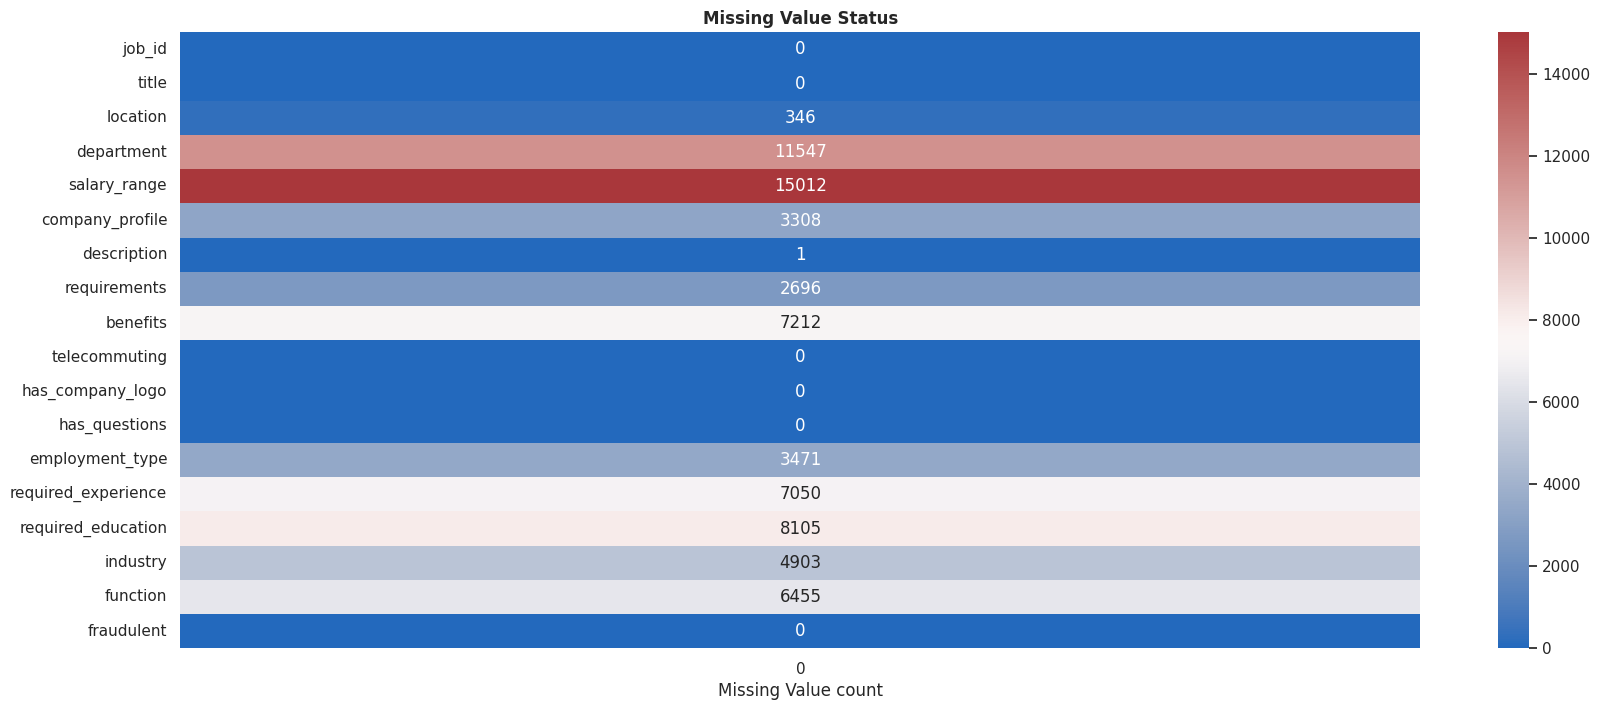

In [190]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Missing Value count')
plt.show()

In [191]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

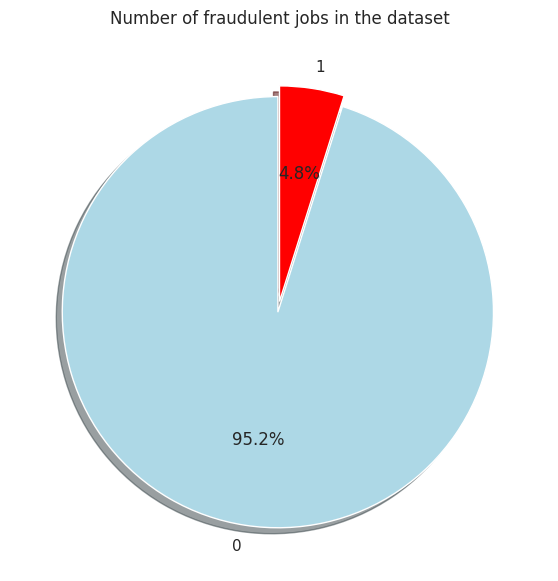

In [192]:
labels =df['fraudulent'].value_counts(sort = True).index
sizes = df['fraudulent'].value_counts(sort = True)

colors = ["lightblue","red"]
explode = (0.05,0)

plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Number of fraudulent jobs in the dataset')
plt.show()

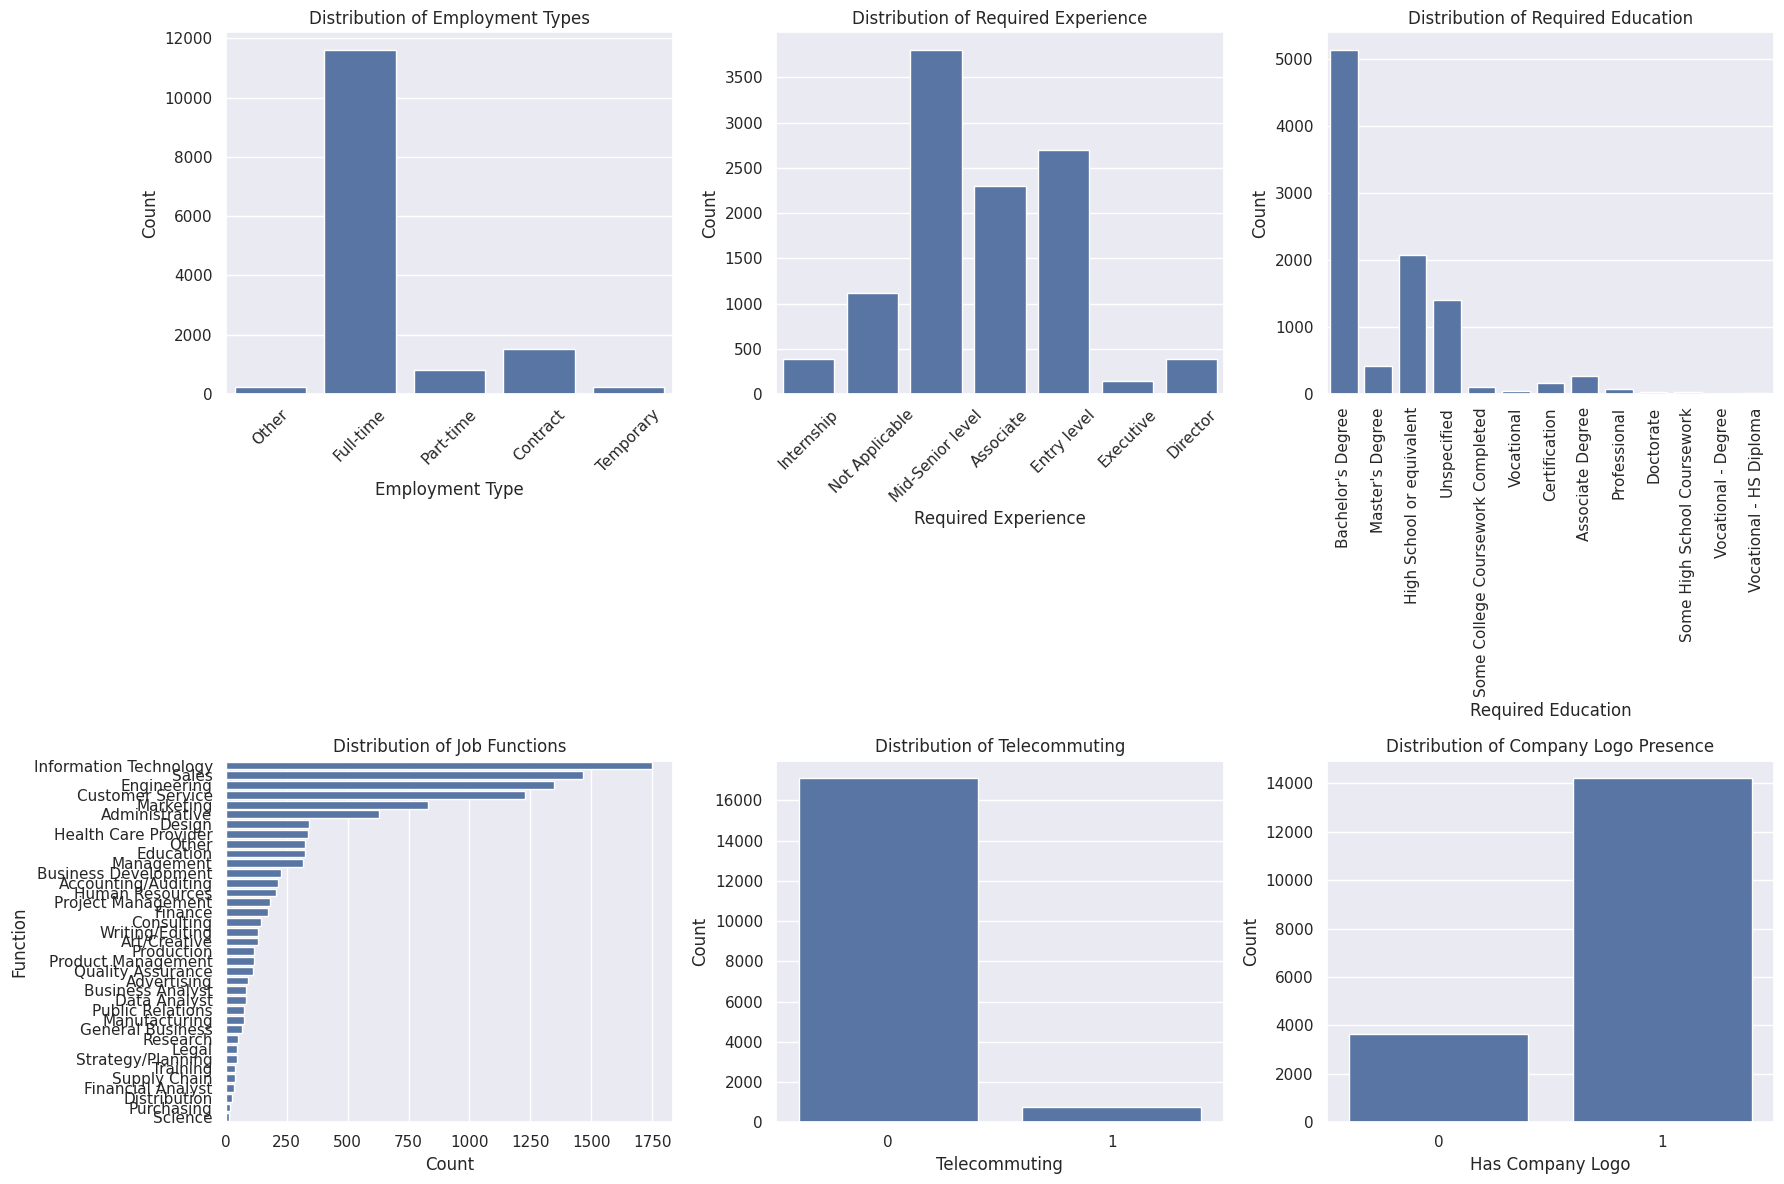

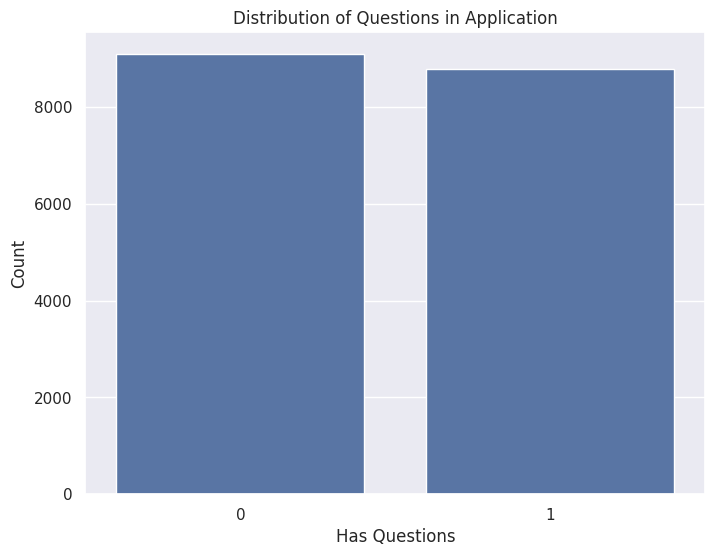

In [193]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Visualize the distribution of employment types
sns.countplot(x='employment_type', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Employment Types')
axes[0, 0].set_xlabel('Employment Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Visualize the distribution of required experience
sns.countplot(x='required_experience', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Required Experience')
axes[0, 1].set_xlabel('Required Experience')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Visualize the distribution of required education
sns.countplot(x='required_education', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Required Education')
axes[0, 2].set_xlabel('Required Education')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=90)

# Visualize the distribution of job functions
sns.countplot(y='function', data=df, order=df['function'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Job Functions')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Function')

# Visualize the distribution of telecommuting
sns.countplot(x='telecommuting', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Telecommuting')
axes[1, 1].set_xlabel('Telecommuting')
axes[1, 1].set_ylabel('Count')

# Visualize the distribution of company logo presence
sns.countplot(x='has_company_logo', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Company Logo Presence')
axes[1, 2].set_xlabel('Has Company Logo')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Visualize the distribution of questions in the application
plt.figure(figsize=(8, 6))
sns.countplot(x='has_questions', data=df)
plt.title('Distribution of Questions in Application')
plt.xlabel('Has Questions')
plt.ylabel('Count')
plt.show()


Just by this brief looking we report two things this dataset is very unbanlaced and also we go some missing values.

# **Data Visualization**

In [160]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [161]:
data_types = df.dtypes

# Separate numerical and categorical columns
numerical_cols = data_types[data_types != 'object'].index
categorical_cols = data_types[data_types == 'object'].index

print("Numerical columns:")
print(numerical_cols)

print("\nCategorical columns:")
print(categorical_cols)

Numerical columns:
Index(['job_id', 'telecommuting', 'has_company_logo', 'has_questions',
       'fraudulent'],
      dtype='object')

Categorical columns:
Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function'],
      dtype='object')


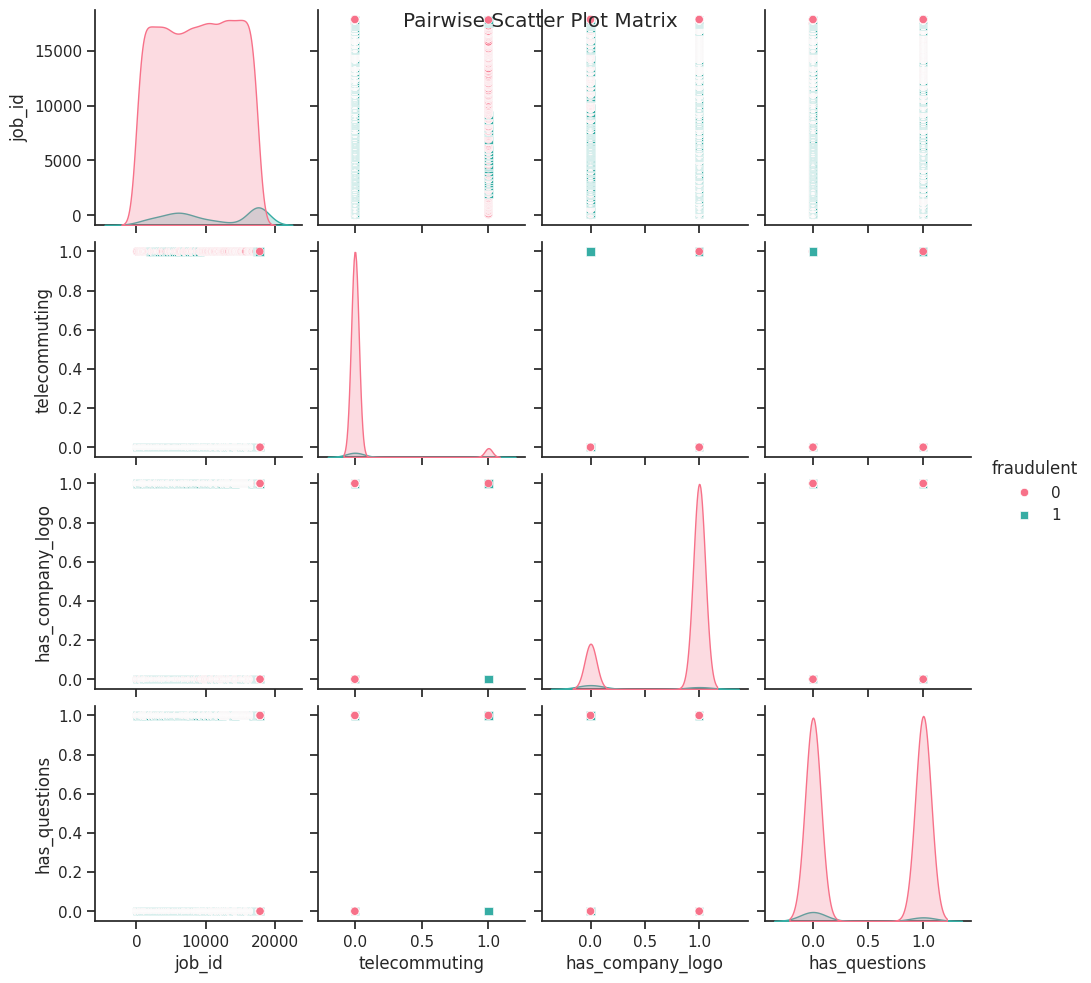

In [162]:
# Pairwise Scatter Plot Matrix: Is a set of scatter plots that visualize the relationships between pairs of numerical variables in our dataset.
sns.set(style="ticks")
sns.pairplot(df, hue="fraudulent", diag_kind="kde", markers=["o", "s"], palette="husl")
plt.suptitle("Pairwise Scatter Plot Matrix")
plt.show()

# **Data Pre Processing**

In [163]:
# 1. Handling Missing Values

# Fill missing values with appropriate strategies
df['employment_type'].fillna(df['employment_type'].mode()[0], inplace=True)
df['required_experience'].fillna(df['required_experience'].mode()[0], inplace=True)
df['required_education'].fillna(df['required_education'].mode()[0], inplace=True)
df['industry'].fillna(df['industry'].mode()[0], inplace=True)
df['function'].fillna(df['function'].mode()[0], inplace=True)
df['salary_range'].fillna(df['salary_range'].mode()[0], inplace=True)

# 1. Drop the 'department' column
df.drop('department', axis=1, inplace=True)

# 2. Handling missing values in text-based columns
text_columns = ['company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Not provided')

# Now, let's check for missing values again
print(df.isnull().sum())

#  Using Lable encoding
le = LabelEncoder()
df = df.apply(le.fit_transform)
df.head()

# 3. Feature Selection/Engineering (if needed)

# Now, split the data into features (X) and target variable (y)
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']

# Split the data into training and testing sets
OGx_train, OGx_test, OGy_train, OGy_test = train_test_split(X, y, test_size=0.2, random_state=23)

job_id                   0
title                    0
location               346
salary_range             0
company_profile          0
description              0
requirements             0
benefits                 0
telecommuting            0
has_company_logo         0
has_questions            0
employment_type          0
required_experience      0
required_education       0
industry                 0
function                 0
fraudulent               0
dtype: int64


Text(0.05, 1.02, 'Correlation features with target')

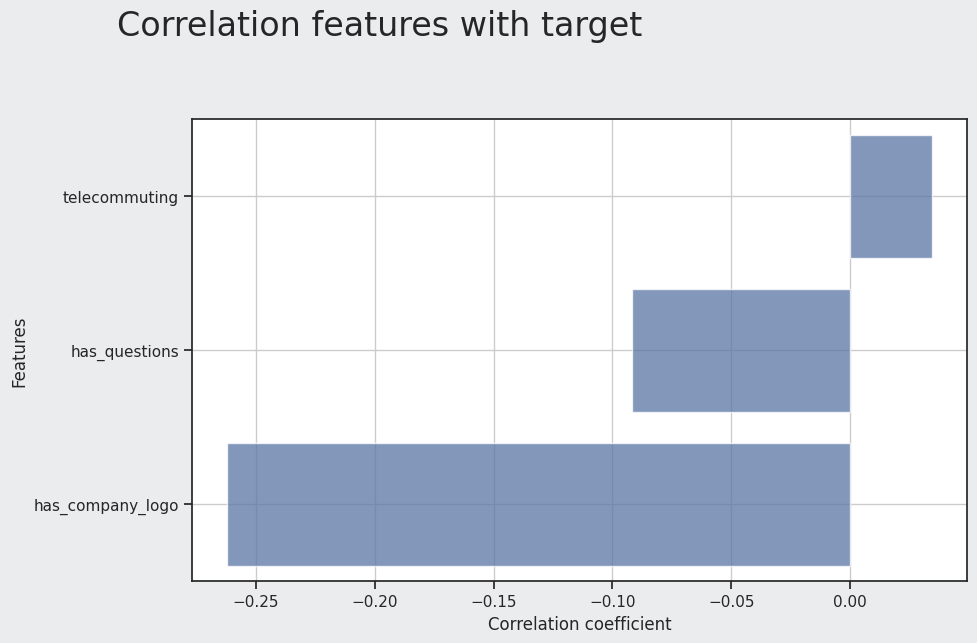

In [164]:
from matplotlib.offsetbox import AnchoredText

features=['telecommuting', 'has_company_logo', 'has_questions']
correlation_table = []
for cols in features:
    y = df["fraudulent"]
    x = df[cols]
    corr = np.corrcoef(x, y)[1][0]
    dict ={
        'Features': cols,
        'Correlation coefficient' : corr,
        'Feat_type': 'numerical'
    }
    correlation_table.append(dict)

dF1 = pd.DataFrame(correlation_table)
fig = plt.figure(figsize=(10,6), facecolor='#EAECEE')
ax = sns.barplot(x="Correlation coefficient", y="Features",
                     data=dF1.sort_values("Correlation coefficient", ascending=False),
                    alpha=0.75,legend=False)
ax.grid()
#ax.set_title("Correlation of numerical features with Target", fontsize=20, y=1.05)

title =  'Correlation features with target'

plt.gcf().text(0.05, 1.02, title, fontsize=24)

## Modeling

In [165]:
models_score = run_exp_on_feature(OGx_train,OGy_train,OGx_test,OGy_test)


 [[3394    4]
 [ 156   22]]
Logistic Regression
Validation Acuuracy:  0.9552572706935123
Training Accuracy:  0.9540687919463087
############################################








 [[3357   41]
 [  37  141]]
Decision Tree Classifier
Validation Acuuracy:  0.9781879194630873
Training Accuracy:  1.0
############################################








 [[3398    0]
 [  56  122]]
Random Forest Classifier
Validation Acuuracy:  0.9843400447427293
Training Accuracy:  1.0
############################################








 [[3390    8]
 [  39  139]]
XGBoost
Validation Acuuracy:  0.9868568232662193
Training Accuracy:  0.9998601789709173
############################################








 [[3398    0]
 [ 178    0]]
SVM
Validation Acuuracy:  0.9502237136465325
Training Accuracy:  0.9519015659955258
############################################




In [166]:
metrics_normal = get_comparision_table(models_score)


+----+--------------------------+------------+-------------+----------+------------+
|    | Model                    |   Accuracy |   Precision |   Recall |   F1 Score |
+====+==========================+============+=============+==========+============+
|  0 | Logistic Regression      |   0.955257 |    0.846154 | 0.123596 |   0.215686 |
+----+--------------------------+------------+-------------+----------+------------+
|  1 | Decision Tree Classifier |   0.978188 |    0.774725 | 0.792135 |   0.783333 |
+----+--------------------------+------------+-------------+----------+------------+
|  2 | Random Forest Classifier |   0.98434  |    1        | 0.685393 |   0.813333 |
+----+--------------------------+------------+-------------+----------+------------+
|  3 | XGBoost                  |   0.986857 |    0.945578 | 0.780899 |   0.855385 |
+----+--------------------------+------------+-------------+----------+------------+
|  4 | SVM                      |   0.950224 |    1        | 0   

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.955257,0.846154,0.123596,0.215686
1,Decision Tree Classifier,0.978188,0.774725,0.792135,0.783333
2,Random Forest Classifier,0.984340,1.000000,0.685393,0.813333
3,XGBoost,0.986857,0.945578,0.780899,0.855385
4,SVM,0.950224,1.000000,0.000000,0.000000


# SMOTE Approach

In consideration of the performance analysis of various machine learning models conducted on the dataset, which displays an imbalanced class distribution, we intend to enhance the predictive capabilities of these models through the implementation of the Synthetic Minority Over-sampling Technique (SMOTE). The observed low precision, recall, and F1 score values, particularly for the minority class, suggest that class imbalance may be adversely affecting model performance. By applying SMOTE, our aim is to address this issue by generating synthetic instances for the minority class, thereby achieving a more balanced dataset. This strategic approach is expected to improve the models' ability to capture the complexities of both classes and subsequently enhance their overall classification performance.

In [167]:
sm = SMOTE()
X_smote, y_smote = sm.fit_resample(OGx_train,OGy_train)

x_train_smote,x_test_smote,y_train_smote,y_test_smote = train_test_split(X_smote,y_smote,test_size=0.2,random_state=23)

print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_smote==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote==0)))


Before OverSampling, counts of label '1': 866
Before OverSampling, counts of label '0': 17014 

After OverSampling, the shape of train_X: (27232, 16)
After OverSampling, the shape of train_y: (27232,) 

After OverSampling, counts of label '1': 13616
After OverSampling, counts of label '0': 13616


**Baseline accuracy**
It refers to the accuracy achieved by a simple model that always predicts the majority class. In binary classification problems like this one, where you have two classes, the majority class is the one that occurs most frequently in the dataset.

Here, before applying SMOTE (Synthetic Minority Over-sampling Technique), you had class imbalances, meaning one class (likely the majority class, labeled '0') dominated the dataset, while the other class (likely the minority class, labeled '1') was underrepresented.

So, the baseline accuracy represents the accuracy achieved if you were to predict the majority class for every instance. In this case, since class '0' is the majority class, the baseline accuracy would be the proportion of instances in your training data that belong to class '0'.

By printing y_train_smote.value_counts(normalize=True).max(), you calculated this baseline accuracy. It's essentially the percentage of the majority class in your training data after SMOTE.

In [168]:
# Calculate baseline accuracy
accuracy_baseline_smote = y_train_smote.value_counts(normalize=True).max()
print("Baseline Accuracy:", accuracy_baseline_smote)

Baseline Accuracy: 0.5025017213679137


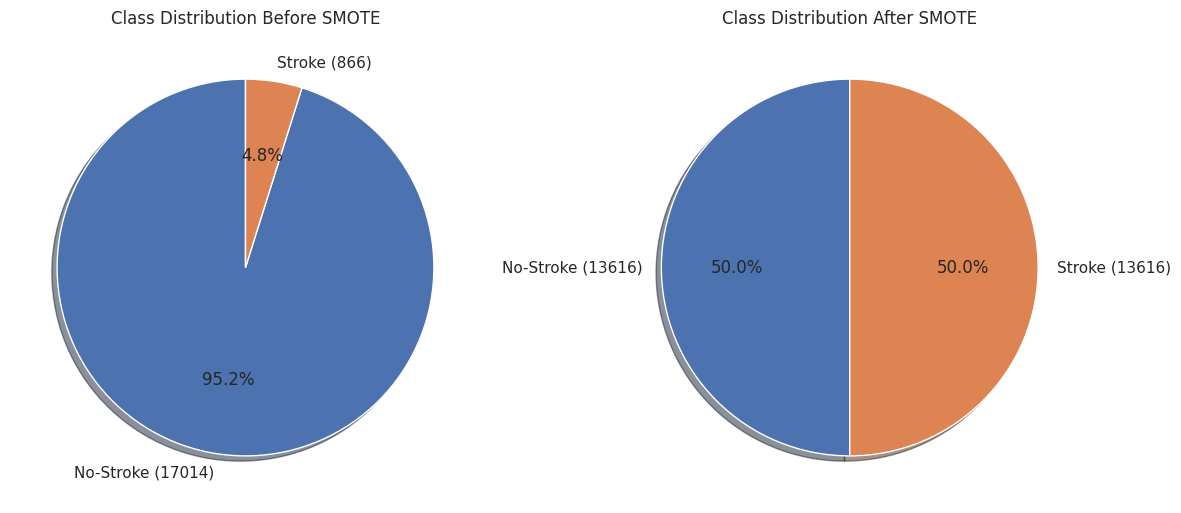

In [169]:
# Calculate the class proportions
original_counts = y.value_counts()
smote_counts = y_smote.value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for original data
labels_original = [f"No-Stroke ({original_counts[0]})", f"Stroke ({original_counts[1]})"]
axs[0].pie(original_counts, labels=labels_original, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].set_title("Class Distribution Before SMOTE")

# Pie chart for SMOTE data
labels_smote = [f"No-Stroke ({smote_counts[0]})", f"Stroke ({smote_counts[1]})"]
axs[1].pie(smote_counts, labels=labels_smote, autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].set_title("Class Distribution After SMOTE")

plt.tight_layout()
plt.show()


In [170]:
models_score_smote = run_exp_on_feature(x_train_smote,y_train_smote,x_test_smote,y_test_smote)


 [[2015  654]
 [ 494 2284]]
Logistic Regression
Validation Acuuracy:  0.7892417844685148
Training Accuracy:  0.7875143447326142
############################################




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression







 [[2579   90]
 [  59 2719]]
Decision Tree Classifier
Validation Acuuracy:  0.9726454929318891
Training Accuracy:  1.0
############################################








 [[2647   22]
 [  24 2754]]
Random Forest Classifier
Validation Acuuracy:  0.9915549843950798
Training Accuracy:  1.0
############################################








 [[2634   35]
 [  13 2765]]
XGBoost
Validation Acuuracy:  0.9911878098035616
Training Accuracy:  0.9996786779894423
############################################








 [[2105  564]
 [ 777 2001]]
SVM
Validation Acuuracy:  0.753809436387002
Training Accuracy:  0.7561165939866881
############################################




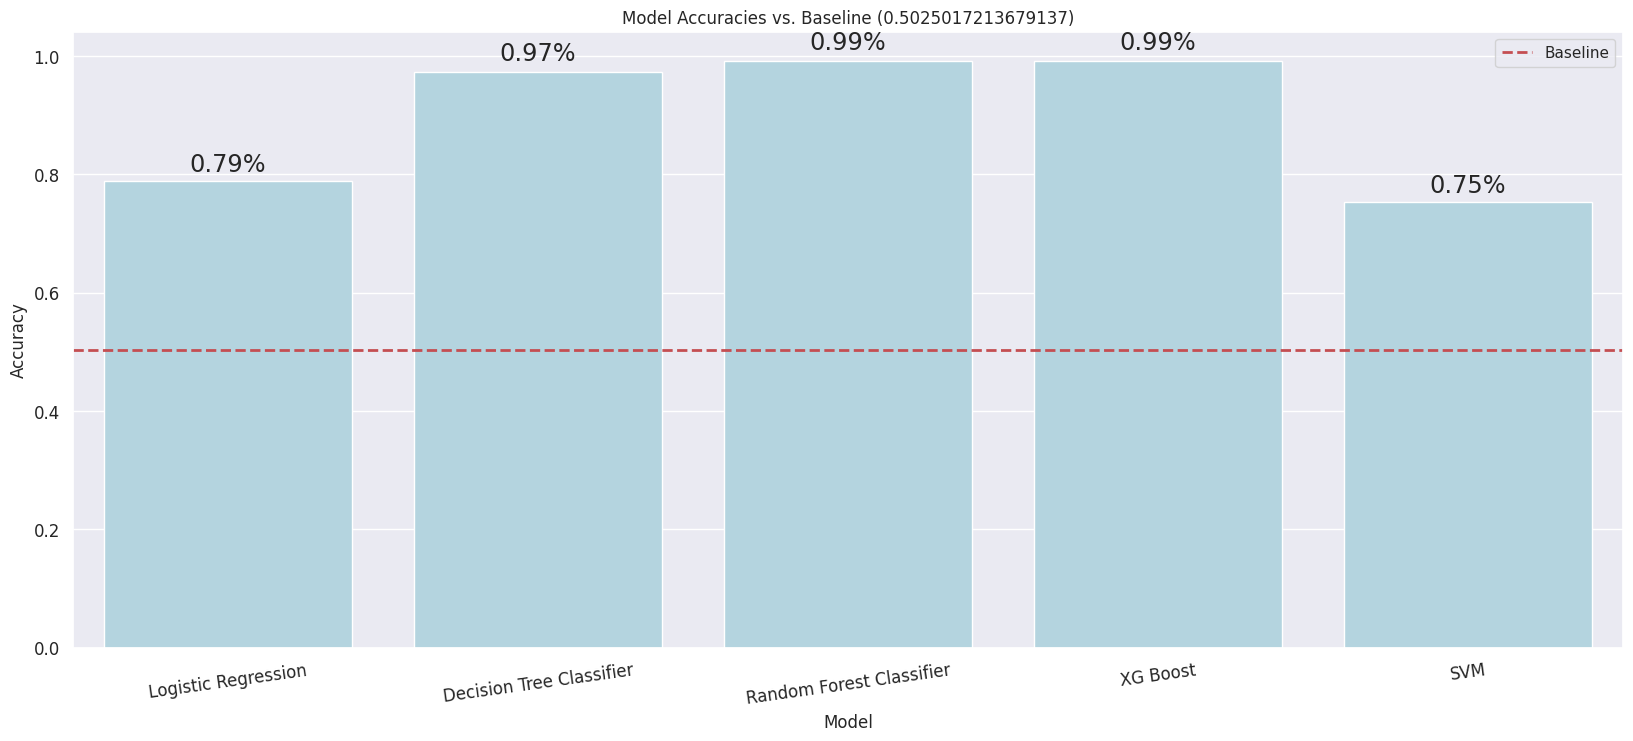

In [171]:
hist_score(models_score_smote.get('Accuracy'),accuracy_baseline_smote)

In [172]:
metrics_smote= get_comparision_table(models_score_smote)

+----+--------------------------+------------+-------------+----------+------------+
|    | Model                    |   Accuracy |   Precision |   Recall |   F1 Score |
+====+==========================+============+=============+==========+============+
|  0 | Logistic Regression      |   0.789242 |    0.7774   | 0.822174 |   0.79916  |
+----+--------------------------+------------+-------------+----------+------------+
|  1 | Decision Tree Classifier |   0.972645 |    0.96796  | 0.978762 |   0.973331 |
+----+--------------------------+------------+-------------+----------+------------+
|  2 | Random Forest Classifier |   0.991555 |    0.992075 | 0.991361 |   0.991718 |
+----+--------------------------+------------+-------------+----------+------------+
|  3 | XGBoost                  |   0.991188 |    0.9875   | 0.99532  |   0.991395 |
+----+--------------------------+------------+-------------+----------+------------+
|  4 | SVM                      |   0.753809 |    0.780117 | 0.72

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.789242,0.777400,0.822174,0.799160
1,Decision Tree Classifier,0.972645,0.967960,0.978762,0.973331
2,Random Forest Classifier,0.991555,0.992075,0.991361,0.991718
3,XGBoost,0.991188,0.987500,0.995320,0.991395
4,SVM,0.753809,0.780117,0.720302,0.749017


# OVER SAMPLING

In scenarios with imbalanced class distributions, undersampling is employed to address the dominance of the majority class. By reducing the number of majority class instances, undersampling aims to rebalance the dataset, enabling models to focus more on the minority class. This allows for better generalization and improved predictive accuracy by ensuring that classifiers learn from both classes' nuances effectively.

Before Oversampling, counts of label '1': 866
Before Oversampling, counts of label '0': 17014
After Oversampling, the shape of train_X: (27232, 16)
After Oversampling, the shape of train_y: (27232,)
After Oversampling, counts of label '1': 13616
After Oversampling, counts of label '0': 13616
Baseline Accuracy: 0.5025017213679137


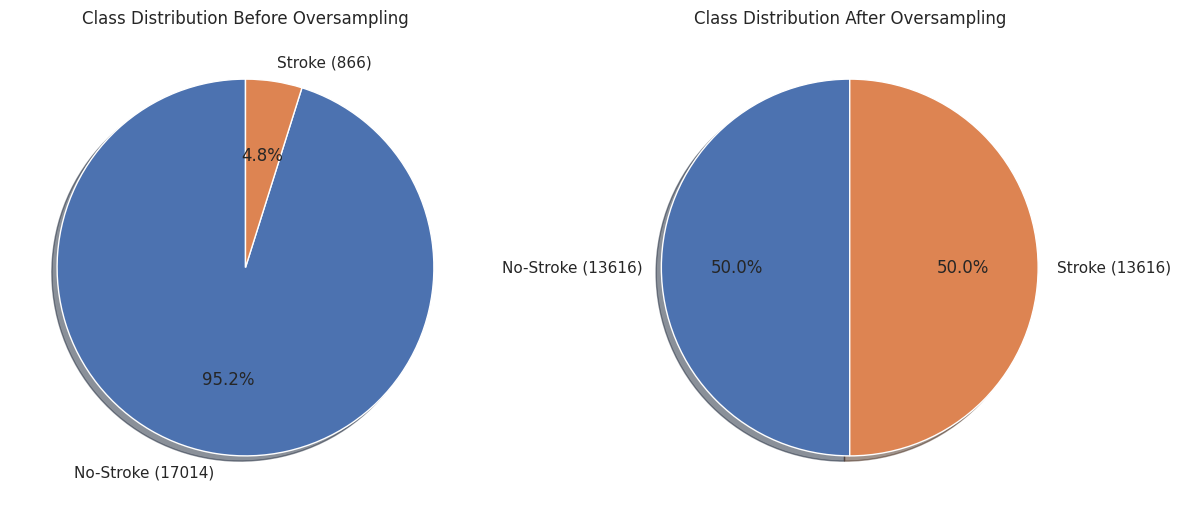

In [173]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Apply oversampling
ros = RandomOverSampler(random_state=23)
X_oversampled, y_oversampled = ros.fit_resample(OGx_train, OGy_train)

# Split oversampled data into train and test sets
x_train_oversampled, x_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=23)

# Display class distribution before and after oversampling
print("Before Oversampling, counts of label '1': {}".format(sum(y == 1)))
print("Before Oversampling, counts of label '0': {}".format(sum(y == 0)))
print('After Oversampling, the shape of train_X: {}'.format(X_oversampled.shape))
print('After Oversampling, the shape of train_y: {}'.format(y_oversampled.shape))
print("After Oversampling, counts of label '1': {}".format(sum(y_oversampled == 1)))
print("After Oversampling, counts of label '0': {}".format(sum(y_oversampled == 0)))

# Calculate baseline accuracy
accuracy_baseline_oversampled = y_train_oversampled.value_counts(normalize=True).max()
print("Baseline Accuracy:", accuracy_baseline_oversampled)

# Create subplots for class distribution comparison
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for original data
labels_original = [f"No-Stroke ({original_counts[0]})", f"Stroke ({original_counts[1]})"]
axs[0].pie(original_counts, labels=labels_original, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].set_title("Class Distribution Before Oversampling")

# Pie chart for oversampled data
oversampled_counts = y_oversampled.value_counts()
labels_oversampled = [f"No-Stroke ({oversampled_counts[0]})", f"Stroke ({oversampled_counts[1]})"]
axs[1].pie(oversampled_counts, labels=labels_oversampled, autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].set_title("Class Distribution After Oversampling")

plt.tight_layout()
plt.show()

# Now you can proceed with your models' training and evaluation using x_train_oversampled, y_train_oversampled, x_test_oversampled, and y_test_oversampled


In [174]:
models_score_oversampling = run_exp_on_feature(x_train_oversampled,y_train_oversampled,x_test_oversampled,y_test_oversampled)


 [[2084  585]
 [ 645 2133]]
Logistic Regression
Validation Acuuracy:  0.7741876262162658
Training Accuracy:  0.7675005737893046
############################################




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression







 [[2630   39]
 [   0 2778]]
Decision Tree Classifier
Validation Acuuracy:  0.9928400954653938
Training Accuracy:  1.0
############################################








 [[2666    3]
 [   0 2778]]
Random Forest Classifier
Validation Acuuracy:  0.9994492381127226
Training Accuracy:  1.0
############################################








 [[2654   15]
 [   0 2778]]
XGBoost
Validation Acuuracy:  0.997246190563613
Training Accuracy:  0.9998163874225384
############################################








 [[2099  570]
 [ 840 1938]]
SVM
Validation Acuuracy:  0.7411419129796218
Training Accuracy:  0.7434014229974754
############################################




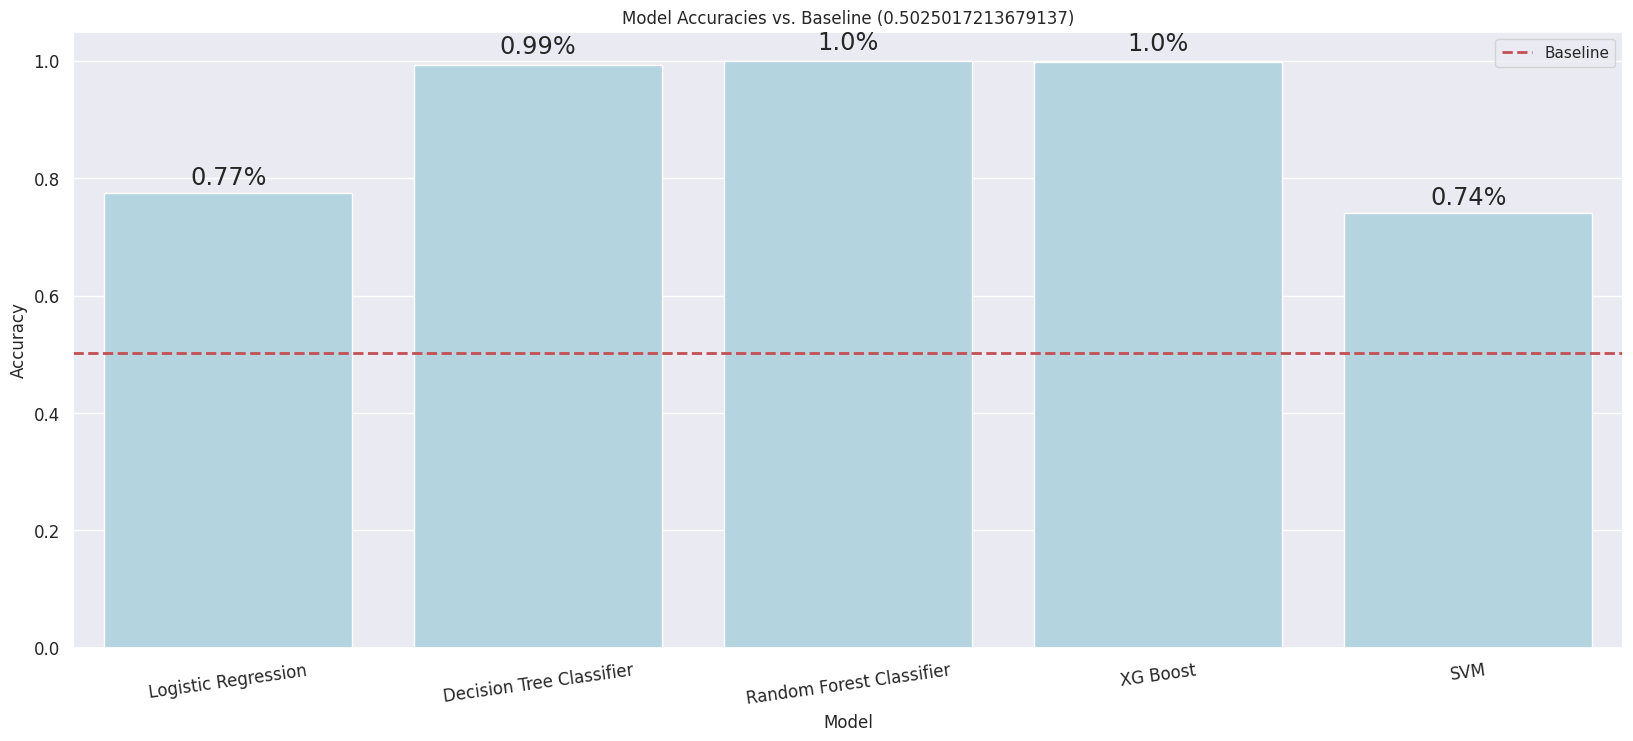

In [175]:
hist_score(models_score_oversampling.get('Accuracy'),accuracy_baseline_oversampled)


In [176]:
metrics_oversampling = get_comparision_table(models_score_oversampling)

+----+--------------------------+------------+-------------+----------+------------+
|    | Model                    |   Accuracy |   Precision |   Recall |   F1 Score |
+====+==========================+============+=============+==========+============+
|  0 | Logistic Regression      |   0.774188 |    0.784768 | 0.767819 |   0.776201 |
+----+--------------------------+------------+-------------+----------+------------+
|  1 | Decision Tree Classifier |   0.99284  |    0.986155 | 1        |   0.993029 |
+----+--------------------------+------------+-------------+----------+------------+
|  2 | Random Forest Classifier |   0.999449 |    0.998921 | 1        |   0.99946  |
+----+--------------------------+------------+-------------+----------+------------+
|  3 | XGBoost                  |   0.997246 |    0.994629 | 1        |   0.997307 |
+----+--------------------------+------------+-------------+----------+------------+
|  4 | SVM                      |   0.741142 |    0.772727 | 0.69

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.774188,0.784768,0.767819,0.776201
1,Decision Tree Classifier,0.992840,0.986155,1.000000,0.993029
2,Random Forest Classifier,0.999449,0.998921,1.000000,0.999460
3,XGBoost,0.997246,0.994629,1.000000,0.997307
4,SVM,0.741142,0.772727,0.697624,0.733258


# UNDER SAMPLING

In imbalanced classification scenarios, where one class dominates the dataset, undersampling is a method to rectify the imbalance by reducing the prevalence of the majority class. By strategically decreasing the number of majority class instances, undersampling aims to create a more balanced dataset, allowing models to focus better on the minority class. This facilitates improved generalization and predictive accuracy by ensuring that classifiers learn from both classes more effectively.

Before Undersampling, counts of label '1': 866
Before Undersampling, counts of label '0': 17014
After Undersampling, the shape of train_X: (1376, 16)
After Undersampling, the shape of train_y: (1376,)
After Undersampling, counts of label '1': 688
After Undersampling, counts of label '0': 688
Baseline Accuracy: 0.5145454545454545


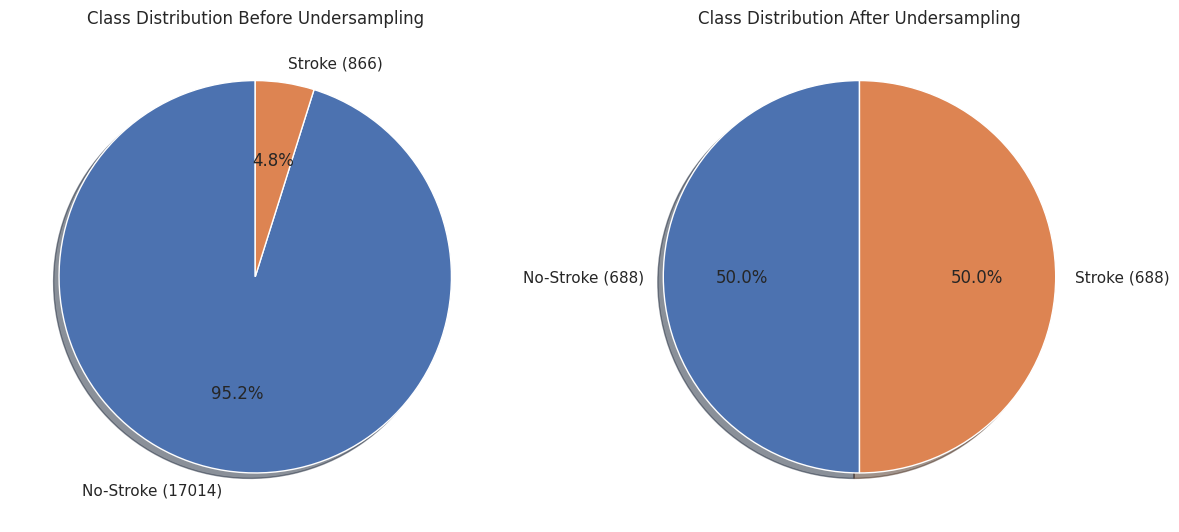

In [177]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Apply undersampling
rus = RandomUnderSampler(random_state=23)
X_undersampled, y_undersampled = rus.fit_resample(OGx_train, OGy_train)

# Split undersampled data into train and test sets
x_train_undersampled, x_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=23)

# Display class distribution before and after undersampling
print("Before Undersampling, counts of label '1': {}".format(sum(y == 1)))
print("Before Undersampling, counts of label '0': {}".format(sum(y == 0)))
print('After Undersampling, the shape of train_X: {}'.format(X_undersampled.shape))
print('After Undersampling, the shape of train_y: {}'.format(y_undersampled.shape))
print("After Undersampling, counts of label '1': {}".format(sum(y_undersampled == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_undersampled == 0)))

# Calculate baseline accuracy
accuracy_baseline_undersampled = y_train_undersampled.value_counts(normalize=True).max()
print("Baseline Accuracy:", accuracy_baseline_undersampled)

# Create subplots for class distribution comparison
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for original data
labels_original = [f"No-Stroke ({original_counts[0]})", f"Stroke ({original_counts[1]})"]
axs[0].pie(original_counts, labels=labels_original, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].set_title("Class Distribution Before Undersampling")

# Pie chart for undersampled data
undersampled_counts = y_undersampled.value_counts()
labels_undersampled = [f"No-Stroke ({undersampled_counts[0]})", f"Stroke ({undersampled_counts[1]})"]
axs[1].pie(undersampled_counts, labels=labels_undersampled, autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].set_title("Class Distribution After Undersampling")

plt.tight_layout()
plt.show()

In [178]:
models_score_undersampling = run_exp_on_feature(x_train_undersampled,y_train_undersampled,x_test_undersampled,y_test_undersampled)


 [[ 95  27]
 [ 34 120]]
Logistic Regression
Validation Acuuracy:  0.7789855072463768
Training Accuracy:  0.7727272727272727
############################################




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression







 [[107  15]
 [ 24 130]]
Decision Tree Classifier
Validation Acuuracy:  0.8586956521739131
Training Accuracy:  1.0
############################################








 [[114   8]
 [ 12 142]]
Random Forest Classifier
Validation Acuuracy:  0.927536231884058
Training Accuracy:  1.0
############################################








 [[116   6]
 [ 12 142]]
XGBoost
Validation Acuuracy:  0.9347826086956522
Training Accuracy:  1.0
############################################








 [[97 25]
 [88 66]]
SVM
Validation Acuuracy:  0.5905797101449275
Training Accuracy:  0.61
############################################




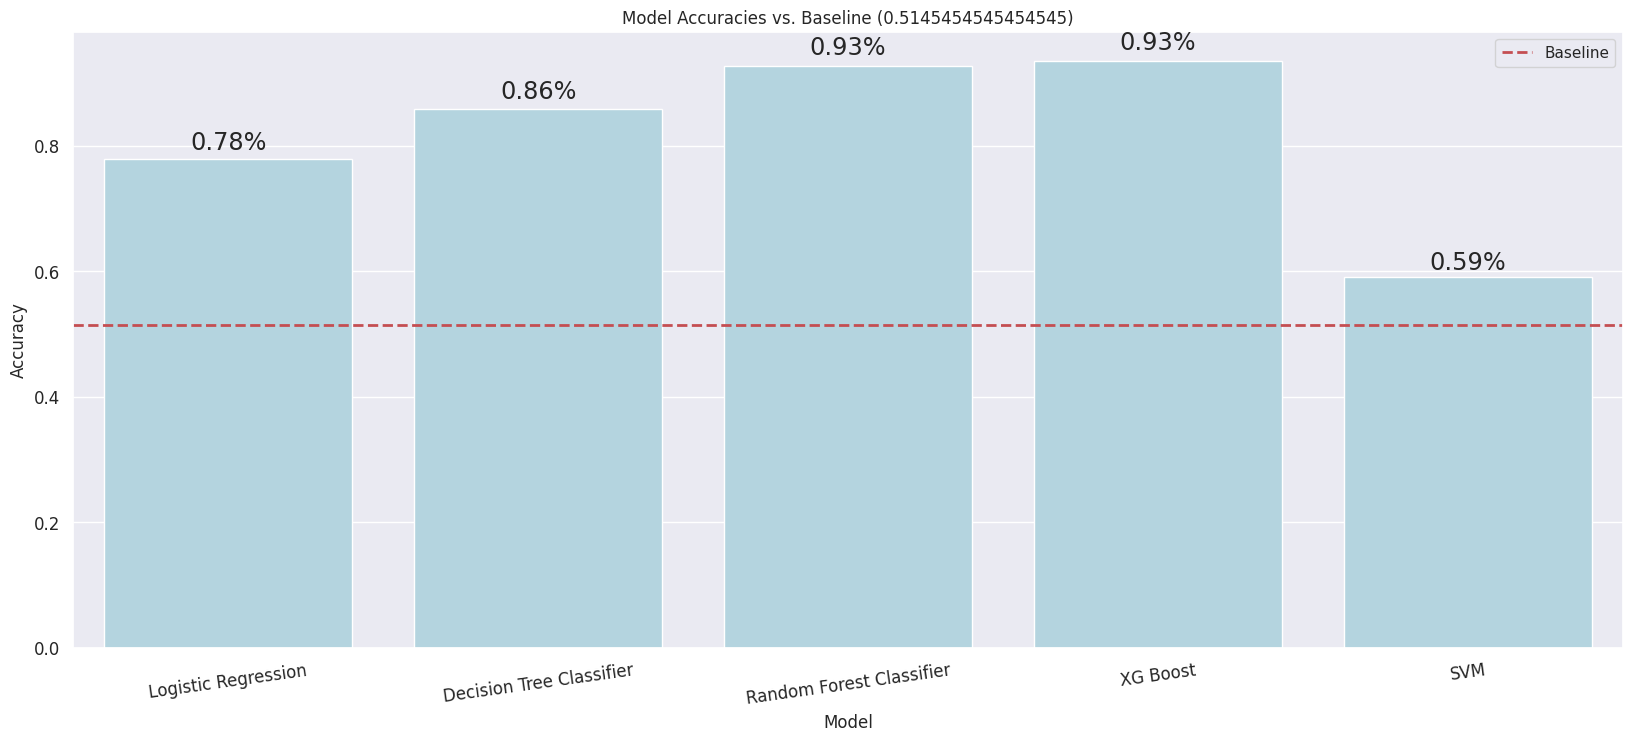

In [179]:
hist_score(models_score_undersampling.get('Accuracy'),accuracy_baseline_undersampled)


In [180]:
metrics_undersampling = get_comparision_table(models_score_undersampling)

+----+--------------------------+------------+-------------+----------+------------+
|    | Model                    |   Accuracy |   Precision |   Recall |   F1 Score |
+====+==========================+============+=============+==========+============+
|  0 | Logistic Regression      |   0.778986 |    0.816327 | 0.779221 |   0.797342 |
+----+--------------------------+------------+-------------+----------+------------+
|  1 | Decision Tree Classifier |   0.858696 |    0.896552 | 0.844156 |   0.869565 |
+----+--------------------------+------------+-------------+----------+------------+
|  2 | Random Forest Classifier |   0.927536 |    0.946667 | 0.922078 |   0.934211 |
+----+--------------------------+------------+-------------+----------+------------+
|  3 | XGBoost                  |   0.934783 |    0.959459 | 0.922078 |   0.940397 |
+----+--------------------------+------------+-------------+----------+------------+
|  4 | SVM                      |   0.59058  |    0.725275 | 0.42

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.778986,0.816327,0.779221,0.797342
1,Decision Tree Classifier,0.858696,0.896552,0.844156,0.869565
2,Random Forest Classifier,0.927536,0.946667,0.922078,0.934211
3,XGBoost,0.934783,0.959459,0.922078,0.940397
4,SVM,0.590580,0.725275,0.428571,0.538776


# Visualization

In [182]:
import plotly.graph_objects as go
import pandas as pd

# Create figure
import pandas as pd
# Merge all DataFrames
df = metrics_normal.merge(metrics_smote, on='Model', suffixes=('_normal', '_SMOTE')) \
                .merge(metrics_undersampling, on='Model', suffixes=('_SMOTE', '_undersampling')) \
                .merge(metrics_oversampling, on='Model', suffixes=('_undersampling', '_oversampling'))

# Display the resulting DataFrame
print(df,"\n\n")
print(df.shape)
fig = go.Figure()

# Add traces for each metric and sampling technique
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    for sampling in ['normal', 'SMOTE', 'undersampling', 'oversampling']:
        visible = [sampling == 'normal'] * 5
        fig.add_trace(go.Scatter(x=df['Model'], y=df[f'{metric}_{sampling}'], mode='lines+markers', name=f'{sampling} - {metric}', visible='legendonly' if sampling != 'normal' else True))

# Add dropdown menu
buttons = []
for sampling in ['normal', 'SMOTE', 'undersampling', 'oversampling']:
    visible = ['legendonly'] * 4
    visible[['normal', 'SMOTE', 'undersampling', 'oversampling'].index(sampling)] = True
    buttons.append({'method': 'update',
                    'label': sampling,
                    'args': [{'visible': visible},
                             {'title': f'{sampling} Sampling Metrics'}]})

fig.update_layout(updatemenus=[{'buttons': buttons,
                                'direction': 'down',
                                'showactive': True,
                                'x': 0.1,
                                'xanchor': 'left',
                                'y': 1.1,
                                'yanchor': 'top'}])

# Update layout
fig.update_layout(title='Sampling Techniques Metrics',
                  xaxis_title='Model',
                  yaxis_title='Value')

# Show figure
fig.show()


                      Model  Accuracy_normal  Precision_normal  Recall_normal  \
0       Logistic Regression         0.955257          0.846154       0.123596   
1  Decision Tree Classifier         0.978188          0.774725       0.792135   
2  Random Forest Classifier         0.984340          1.000000       0.685393   
3                   XGBoost         0.986857          0.945578       0.780899   
4                       SVM         0.950224          1.000000       0.000000   

   F1 Score_normal  Accuracy_SMOTE  Precision_SMOTE  Recall_SMOTE  \
0         0.215686        0.789242         0.777400      0.822174   
1         0.783333        0.972645         0.967960      0.978762   
2         0.813333        0.991555         0.992075      0.991361   
3         0.855385        0.991188         0.987500      0.995320   
4         0.000000        0.753809         0.780117      0.720302   

   F1 Score_SMOTE  Accuracy_undersampling  Precision_undersampling  \
0        0.799160           

# RESULTS


**1. Undersampling:**

    Logistic Regression: Accuracy = 77.90%, Precision = 81.63%, Recall = 77.92%, F1 Score = 79.73%

    Decision Tree Classifier: Accuracy = 85.87%, Precision = 89.66%, Recall = 84.42%, F1 Score = 86.96%

    Random Forest Classifier: Accuracy = 92.75%, Precision = 94.67%, Recall = 92.21%, F1 Score = 93.42%

    XGBoost: Accuracy = 93.48%, Precision = 95.95%, Recall = 92.21%, F1 Score = 94.03%

    SVM: Accuracy = 59.06%, Precision = 72.53%, Recall = 42.86%, F1 Score = 53.79%

**2. Oversampling:**

    Logistic Regression: Accuracy = 77.42%, Precision = 78.48%, Recall = 76.78%, F1 Score = 77.62%
    
    Decision Tree Classifier: Accuracy = 99.28%, Precision = 98.61%, Recall = 100.0%, F1 Score = 99.30%

    Random Forest Classifier: Accuracy = 99.94%, Precision = 99.89%, Recall = 100.0%, F1 Score = 99.94%

    XGBoost: Accuracy = 99.72%, Precision = 99.46%, Recall = 100.0%, F1 Score = 99.73%

    SVM: Accuracy = 74.11%, Precision = 77.27%, Recall = 69.76%, F1 Score = 73.32%

**3. SMOTE:**

    Logistic Regression: Accuracy = 78.92%, Precision = 77.74%, Recall = 82.21%, F1 Score = 79.91%

    Decision Tree Classifier: Accuracy = 97.26%, Precision = 96.79%, Recall = 97.87%, F1 Score = 97.33%

    Random Forest Classifier: Accuracy = 99.15%, Precision = 99.20%, Recall = 99.13%, F1 Score = 99.17%

    XGBoost: Accuracy = 99.11%, Precision = 98.75%, Recall = 99.53%, F1 Score = 99.13%

    SVM: Accuracy = 75.53%, Precision = 78.01%, Recall = 72.03%, F1 Score = 74.90%


# Based on the summary:

**SMOTE** appears to perform the best across most models, showing high accuracy and balanced performance in terms of precision, recall, and F1-score.

**Oversampling** techniques also yield competitive results, particularly with Decision Tree, Random Forest, and XGBoost models, achieving very high accuracy and balanced metrics.

**Undersampling** shows comparatively lower accuracy and mixed performance in terms of precision, recall, and F1-score, especially with Logistic Regression and SVM models.

Therefore, if you prioritize balanced performance across different metrics, SMOTE appears to be the best sampling technique in this scenario.